In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from copy import deepcopy
from tqdm import tqdm

from ex_simulation import p
from dset import get_dataloader, load_pretrained_model

# adaptive-wavelets modules
from losses import get_loss_f
from train import Trainer
from evaluate import Validator
from transform1d import DWT1d
from utils import get_1dfilts, get_wavefun
from wave_attributions import Attributer
from visualize import cshow, plot_1dfilts, plot_1dreconstruct, plot_wavefun

# load data and model

In [8]:
# load data and model
train_loader, test_loader = get_dataloader(p.data_path,
                                           batch_size=p.batch_size)

model = load_pretrained_model(p.model_path)

# define wavelet

In [10]:
# wavelet transform 
wt = DWT1d(wave=p.wave, mode='zero', J=p.J, init_factor=p.init_factor, noise_factor=p.noise_factor).to(device)

# get image
data = iter(test_loader).next()[0].to(device)
data_t = wt(data)
recon = wt.inverse(data_t)

print("Reconstruction error={:.5f}".format(torch.norm(recon - data)**2/data.size(0)))

# get 1d wavelet filters
filt = get_1dfilts(wt)

Reconstruction error=2037.60510


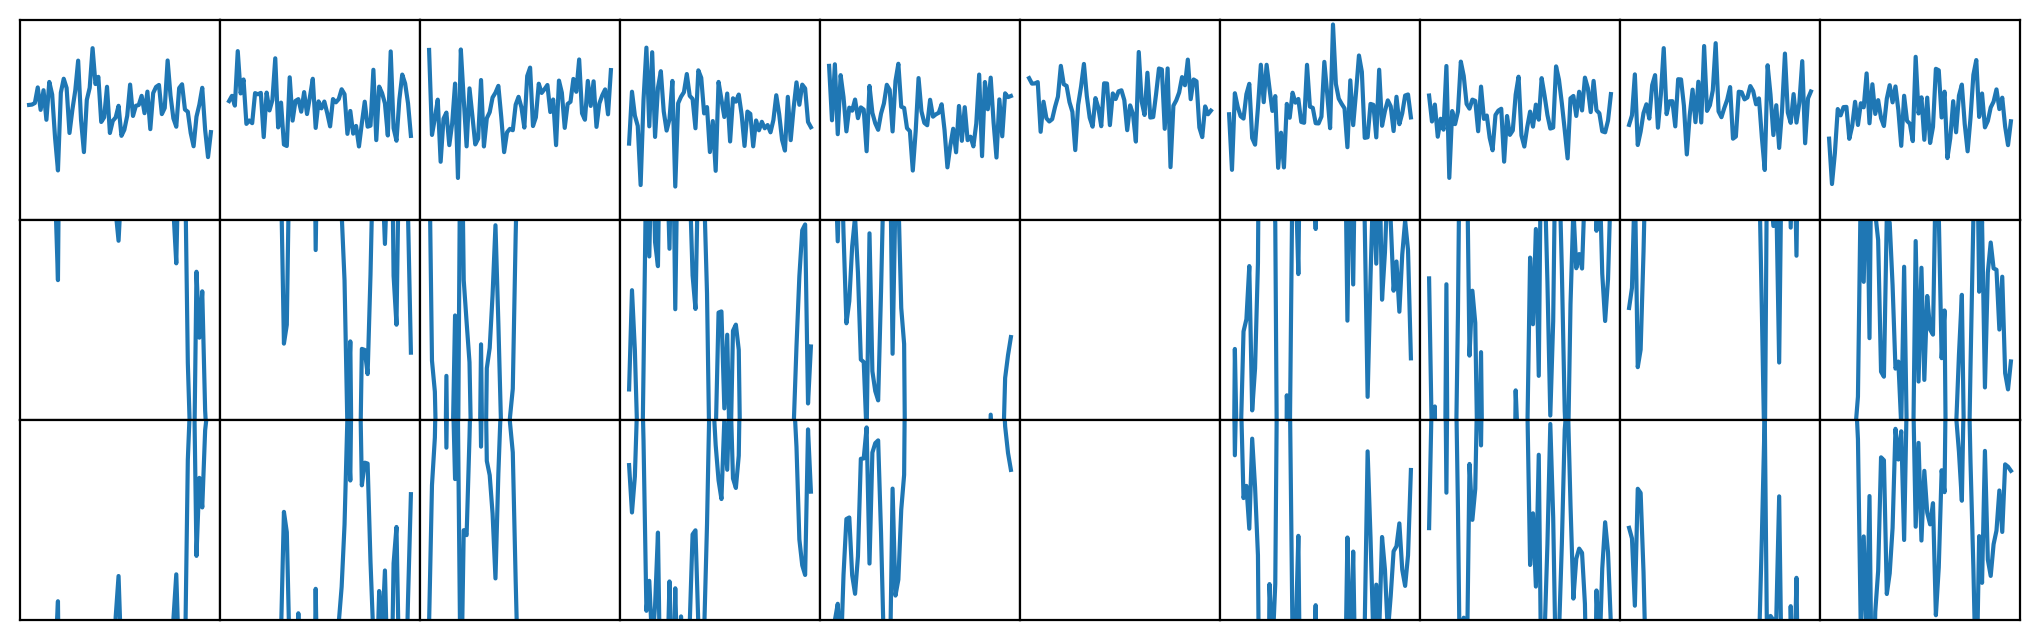

In [5]:
# plot original and reconstruction images
plot_1dreconstruct(data, recon)

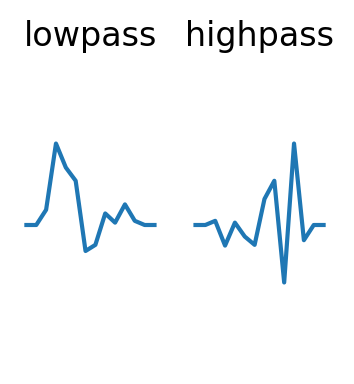

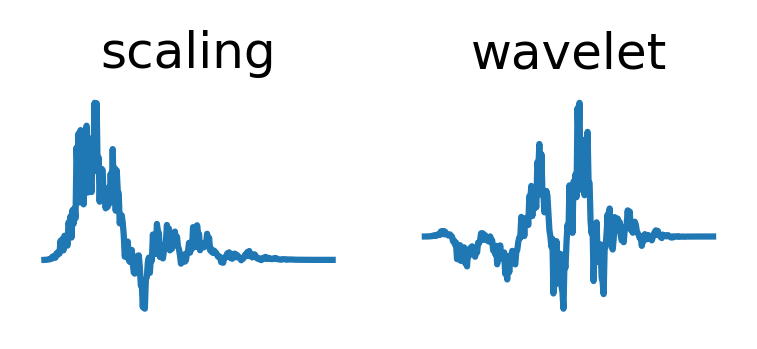

In [6]:
# original wavelet
filt = get_1dfilts(wt)
phi, psi, x = get_wavefun(wt)

plot_1dfilts(filt, is_title=True, figsize=(2,2))

plot_wavefun((phi, psi, x), is_title=True, figsize=(3,1))

# optimize filter

In [7]:
# train
params = list(wt.parameters())
optimizer = torch.optim.Adam(params, lr=0.001)
loss_f = get_loss_f(lamlSum=1, lamhSum=1, lamL2norm=1, lamCMF=1, lamConv=1, lamL1wave=0.01, lamL1attr=1.0)
trainer = Trainer(model, wt, optimizer, loss_f, target=0, 
                  use_residuals=True, attr_methods='Saliency', device=device, n_print=2)

In [8]:
trainer(train_loader, epochs=20)

Starting Training Loop...
Train Epoch: 0 [49900/50000 (100%)]	Loss: 77.484268
====> Epoch: 0 Average train loss: 581.5090
Train Epoch: 2 [49900/50000 (100%)]	Loss: 10.871571
====> Epoch: 2 Average train loss: 14.9095
Train Epoch: 4 [49900/50000 (100%)]	Loss: 5.568894
====> Epoch: 4 Average train loss: 6.3811
Train Epoch: 6 [49900/50000 (100%)]	Loss: 3.708810
====> Epoch: 6 Average train loss: 4.0967
Train Epoch: 8 [49900/50000 (100%)]	Loss: 3.369706
====> Epoch: 8 Average train loss: 3.4291
Train Epoch: 10 [49900/50000 (100%)]	Loss: 3.204337
====> Epoch: 10 Average train loss: 3.2637
Train Epoch: 12 [49900/50000 (100%)]	Loss: 3.016648
====> Epoch: 12 Average train loss: 3.0847
Train Epoch: 14 [49900/50000 (100%)]	Loss: 2.750923
====> Epoch: 14 Average train loss: 2.8209
Train Epoch: 16 [49900/50000 (100%)]	Loss: 2.242228
====> Epoch: 16 Average train loss: 2.4087
Train Epoch: 18 [49900/50000 (100%)]	Loss: 1.670727
====> Epoch: 18 Average train loss: 1.8238


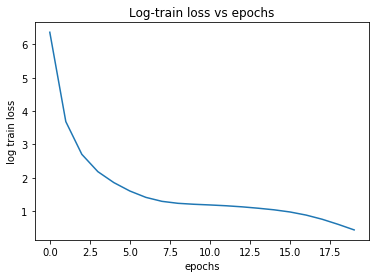

In [9]:
plt.plot(np.log(trainer.train_losses))
plt.xlabel("epochs")
plt.ylabel("log train loss")
plt.title('Log-train loss vs epochs')
plt.show()

In [10]:
data_t = wt(data)
recon = wt.inverse(data_t)

print("Reconstruction error={:.5f}".format(torch.norm(recon - data)**2/data.size(0)))

# get 2d wavelet filters
filt = get_1dfilts(wt)

Reconstruction error=0.00356


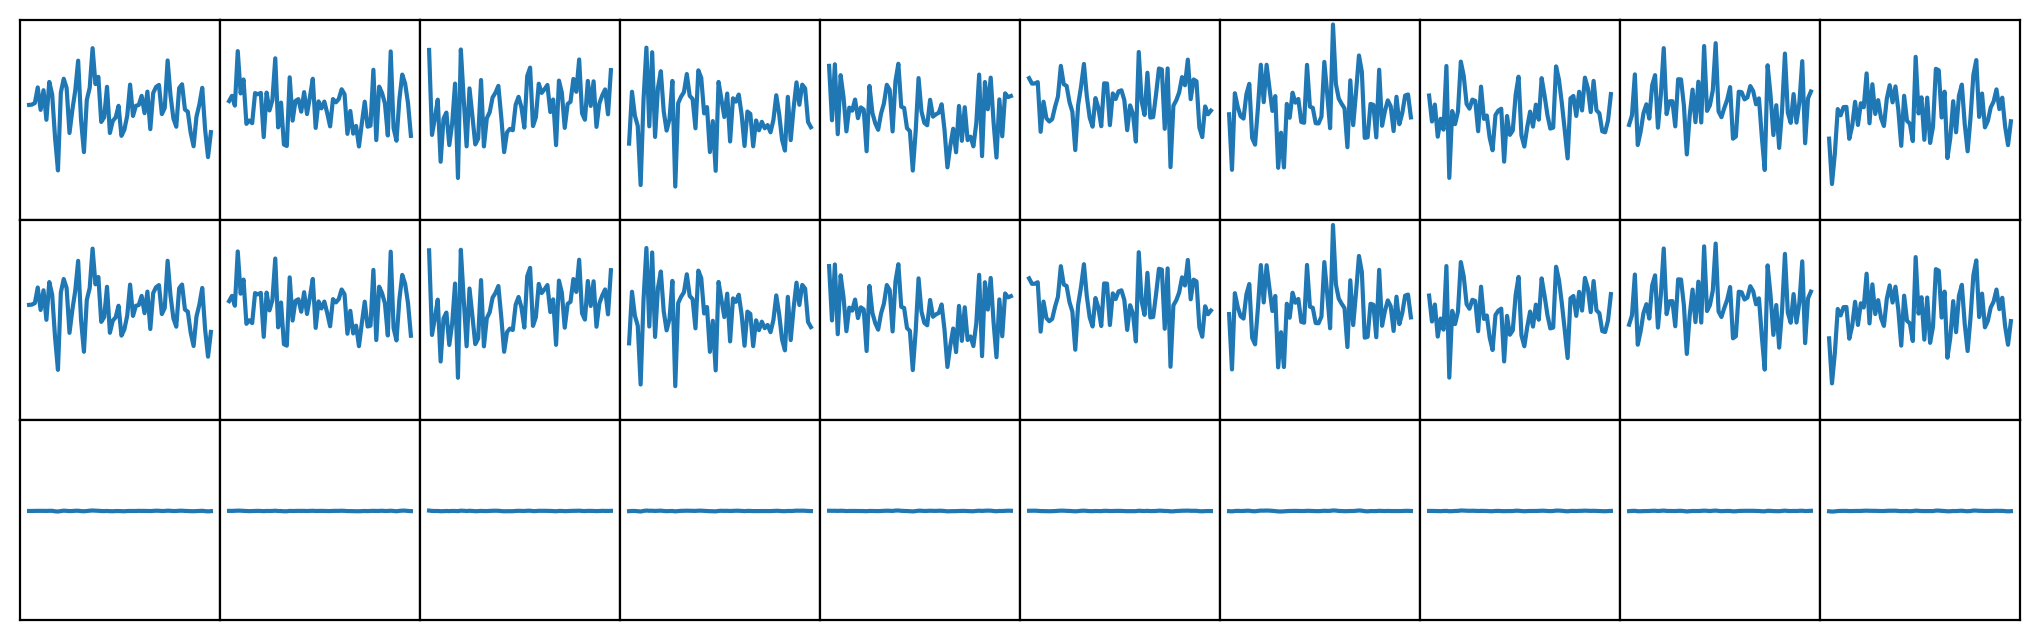

In [11]:
# plot original and reconstruction images
plot_1dreconstruct(data, recon)

# test error

In [12]:
# validator 
validator = Validator(model, test_loader)
rec_loss, lsum_loss, hsum_loss, L2norm_loss, CMF_loss, conv_loss, L1wave_loss, L1saliency_loss, L1inputxgrad_loss = validator(wt, target=0)

# original wavelet transform
wt_o = DWT1d(wave='db5', mode='zero', J=4, init_factor=1, noise_factor=0).to(device)
rec_loss_o, lsum_loss_o, hsum_loss_o, L2norm_loss_o, CMF_loss_o, conv_loss_o, L1wave_loss_o, L1saliency_loss_o, L1inputxgrad_loss_o = validator(wt_o, target=0)

print("\n\n \t Original filter:Reconstruction Error={:.5f} lsum loss={:.5f} hsum loss={:.5f} L2norm loss={:.5f} CMF loss={:.5f} conv loss={:.5f} L1wave loss={:.5f} L1saliency loss={:.5f} L1inputxgrad loss={:.5f} \n \
        Adaptive filter:Reconstruction Error={:.5f} lsum loss={:.5f} hsum loss={:.5f} L2norm loss={:.5f} CMF loss={:.5f} conv loss={:.5f} L1wave loss={:.5f} L1saliency loss={:.5f} L1inputxgrad loss={:.5f}"\
          .format(rec_loss_o, lsum_loss_o, hsum_loss_o, L2norm_loss_o, CMF_loss_o, conv_loss_o, L1wave_loss_o, L1saliency_loss_o, L1inputxgrad_loss_o, 
                  rec_loss, lsum_loss, hsum_loss, L2norm_loss, CMF_loss, conv_loss, L1wave_loss, L1saliency_loss, L1inputxgrad_loss))



 	 Original filter:Reconstruction Error=0.00000 lsum loss=0.00000 hsum loss=0.00000 L2norm loss=0.00000 CMF loss=0.00000 conv loss=0.00000 L1wave loss=10.85556 L1saliency loss=1.32234 L1inputxgrad loss=1.03428 
         Adaptive filter:Reconstruction Error=0.00355 lsum loss=0.00000 hsum loss=0.00079 L2norm loss=0.00001 CMF loss=0.00016 conv loss=0.00001 L1wave loss=10.81210 L1saliency loss=1.33855 L1inputxgrad loss=1.04259


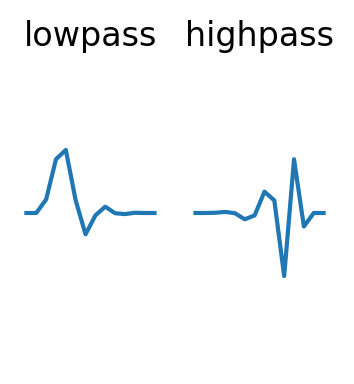

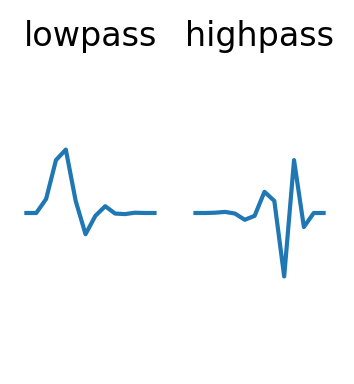

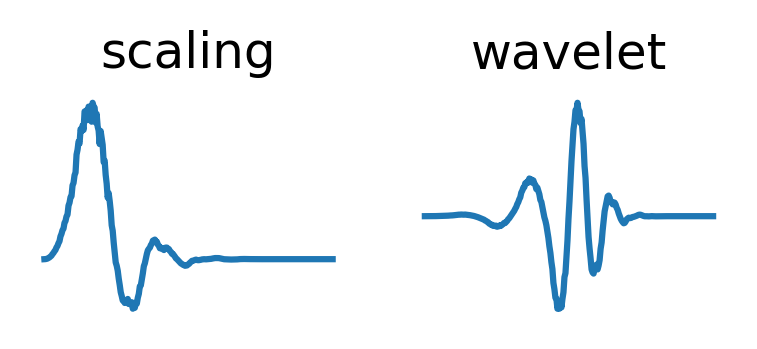

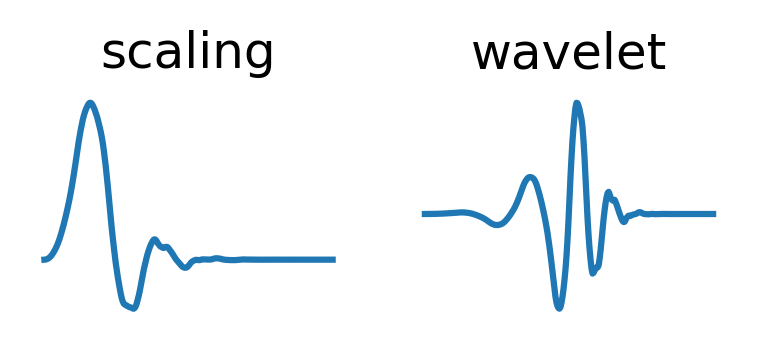

In [13]:
# original wavelet
filt = get_1dfilts(wt)
filt_o = get_1dfilts(wt_o)
phi, psi, x = get_wavefun(wt)
phi_o, psi_o, x_o = get_wavefun(wt_o)

plot_1dfilts(filt, is_title=True, figsize=(2,2))
plot_1dfilts(filt_o, is_title=True, figsize=(2,2))

plot_wavefun((phi, psi, x), is_title=True, figsize=(3,1))
plot_wavefun((phi_o, psi_o, x_o), is_title=True, figsize=(3,1))

In [14]:
# sys.path.append('../../lib/trim')
# from trim import TrimModel
# from utils import tuple_to_tensor, tensor_to_tuple

# mt = TrimModel(model, wt.inverse, use_residuals=True)    
# attributer = Attributer(mt, attr_methods='Saliency', device='cuda')

# b = torch.tensor([]).to(device)
# c = torch.tensor([]).to(device)
# for data, _ in test_loader:
#     data = data.to(device)
#     data_t = wt(data)
#     attributions = attributer(data_t, target=0, additional_forward_args=deepcopy(data))
#     y, _ = tuple_to_tensor(data_t)
#     b = torch.cat((y,b), dim=0)     
#     z, _ = tuple_to_tensor(attributions)
#     c = torch.cat((z,c), dim=0)
# b = b.reshape(-1)
# c = c.reshape(-1)
# sort_indexes = torch.argsort(b, dim=0, descending=False)          
    
# plt.plot(b[sort_indexes].detach().cpu())
# plt.show()

# plt.plot(c[sort_indexes].detach().cpu())
# plt.show()